# Imports, config variables, and data generators

In [1]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Global config variables

# number of truncated backprop steps 
# (n in the discussion at https://r2rt.com/recurrent-neural-networks-in-tensorflow-i)
num_steps = 10
batch_size = 200
num_classes = 2
state_size = 8
learning_rate = 0.1

In [3]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
            
    return X, np.array(Y)

In [4]:
# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)
    
    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i+1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i+1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps
    
    for i in range(epoch_size):
        x = data_x[:, i * num_steps:( i + 1 ) * num_steps]
        y = data_y[:, i * num_steps:( i + 1 ) * num_steps]
        yield (x, y)
        
def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)

# Model

In [5]:
"""
Placeholders
"""
x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
x_one_hot = tf.one_hot(x, num_classes)
rnn_inputs = tf.unstack(x_one_hot, axis=1)

In [6]:
"""
Definition of rnn cell

This is very similiar to the __call__ method on Tensorflow's BasicRnnCell. See: 
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn_cell_impl.py#L95
"""
with tf.variable_scope('rnn_cell'):
    W = tf.get_variable('W', [num_classes + state_size, state_size])
    b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
    
def rnn_cell(rnn_input, state):
    with tf.variable_scope('rnn_cell', reuse=True):
        W = tf.get_variable('W', [num_classes + state_size, state_size])
        b = tf.get_variable('b', [state_size], initializer=tf.constant_initializer(0.0))
        return tf.tanh(tf.matmul(tf.concat([rnn_input, state], 1), W) + b)


In [7]:
"""
Adding rnn_cells to graph

This is a simplified version of the "static_rnn" function from Tensorflow's api. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/rnn/python/ops/core_rnn.py#L41
Note: In practice, using "dynamic_rnn" is a better choice that the "static_rnn":
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/ops/rnn.py#L390
"""
state = init_state
rnn_outputs = []
for rnn_input in rnn_inputs:
    state = rnn_cell(rnn_input, state)
    rnn_outputs.append(state)
final_state = rnn_outputs[-1]

In [8]:
"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""

# logits and predictions 
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))
    
logits = [tf.matmul(rnn_output, W)+b for rnn_output in rnn_outputs]
predictions = [tf.nn.softmax(logit) for logit in logits]

# turn our y placeholder to a list of labels
y_as_list = tf.unstack(y, num=num_steps, axis=1)

# losses & train step
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(labels=label, logits=logit) for \
          logit, label in zip(logits, y_as_list)]
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdagradOptimizer(learning_rate).minimize(total_loss)

In [9]:
"""
Train the network
"""
def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print('\nEPOCH', idx)
                
            for step, (X,Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                             total_loss,
                             final_state,
                             train_step],
                            feed_dict={x:X, y:Y, init_state: training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print('Average loss at step', step,
                             'for last 250 steps:', training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0
    return training_losses

In [15]:
training_losses = train_network(5,num_steps,state_size)
training_losses

('\nEPOCH', 0)
('Average loss at step', 100, 'for last 250 steps:', 0.59769226402044295)
('Average loss at step', 200, 'for last 250 steps:', 0.49369483530521391)
('Average loss at step', 300, 'for last 250 steps:', 0.48730576336383818)
('Average loss at step', 400, 'for last 250 steps:', 0.48461743503808974)
('\nEPOCH', 1)
('Average loss at step', 100, 'for last 250 steps:', 0.4883215284347534)
('Average loss at step', 200, 'for last 250 steps:', 0.48215540409088137)
('Average loss at step', 300, 'for last 250 steps:', 0.47985247641801831)
('Average loss at step', 400, 'for last 250 steps:', 0.48037366837263107)
('\nEPOCH', 2)
('Average loss at step', 100, 'for last 250 steps:', 0.48620146185159685)
('Average loss at step', 200, 'for last 250 steps:', 0.47895208746194839)
('Average loss at step', 300, 'for last 250 steps:', 0.48034776926040651)
('Average loss at step', 400, 'for last 250 steps:', 0.47845098048448564)
('\nEPOCH', 3)
('Average loss at step', 100, 'for last 250 steps:', 

[0.59769226402044295,
 0.49369483530521391,
 0.48730576336383818,
 0.48461743503808974,
 0.4883215284347534,
 0.48215540409088137,
 0.47985247641801831,
 0.48037366837263107,
 0.48620146185159685,
 0.47895208746194839,
 0.48034776926040651,
 0.47845098048448564,
 0.48504458427429198,
 0.47796484857797622,
 0.47785863250494004,
 0.47707359254360199,
 0.48480468988418579,
 0.47752346098423004,
 0.47697118073701861,
 0.47564053446054461]

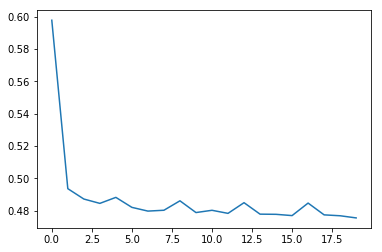

In [16]:
plt.plot(training_losses)